In [21]:
import matplotlib.pylab as plt

In [22]:
% pylab inline

Populating the interactive namespace from numpy and matplotlib


In [23]:
import scipy.stats as stats

In [24]:
from sklearn.cluster import KMeans as kmeans

In [25]:
from PIL import Image

In [26]:
from sklearn.cluster import KMeans as kmeans
import numpy as np 
import os, csv, copy
from PIL import Image

In [27]:
import os, csv, copy

In [28]:
def load_data(subject_id, day= 1, listen=0): 
    """inputs: 'day' = int [1 OR 2]
    returns a list of all subjects in gaze directory matching 'day'"""

    data_file_names = []
    data_path = '../../collection/gaze_data/'
    folder_contents = os.listdir(data_path)
    
    for file in folder_contents: 
        if 'd%s.asc'%day in file and not 'x' in file: 
            data_file_names.append(file)

    for file_name in data_file_names: 
        if str(subject_id) in file_name:    
            if listen: print(file_name, subject_id)
            subject_path = data_path + file_name

    with open(subject_path) as f:
        reader = csv.reader(f, delimiter="\t")
        subject_data = list(reader)

    return subject_data

def extract_data(subject_data): 
    """ 
    inputs: 'subject_data' = raw ascii file 
    returns: np.arrays for pupil, CS+, CS-, US, and movie_frame information 
    
    """

    _pupil_ = [] 
    onsets  = []
    cs_type = []
    xy = []
    xy_time = []
    cs_pos = []; cs_p = 0 # CS+
    cs_neg = []; cs_n = 0 # CS-
    us_sti = []; us_o = 0 # US
    fix_info = []
    fix_duration = []
    fix_xy = []
    fix_time = [] 
    
    # movie frame data prep 
    m_frame, i_frame = [], np.nan

    for i_row in range(len(subject_data)): 

        msg = subject_data[i_row]  

        try: 
            int(subject_data[i_row][0])
            # 3 = pupil column
            datum = float(msg[3]) 
            _pupil_.append(datum)
            cs_pos.append(cs_p)
            cs_neg.append(cs_n)
            us_sti.append(us_o)
            m_frame.append(i_frame)
            
            # extract xy coordinates 
            if ' .' in msg[1] or ' .' in  msg[2]:
                xy.append([np.nan, np.nan])
                xy_time.append(np.nan)
            else: 
                xy.append([float(msg[1]), float(msg[2])])
                xy_time.append(float(msg[0]))
            
        except: 

            if len(msg) > 1: 
                if 'CS+' in msg[1]: cs_p = 1
                if 'CS-' in msg[1]: cs_n = 1
                if 'US'  in msg[1]: 
                    us_o = 1
                    cs_type[-1] =  cs_type[-1] + 'US'
                    
                    
                if 'OFF' in msg[1]: 
                    cs_p = 0
                    cs_n = 0
                    us_o = 0 

                if msg[0] == "MSG": 

                    if "VFRAME" in msg[1]: 

                        ind = str.find(msg[1], "VFRAME")
                        space = str.find(msg[1], " 0 0 /")
                        if space == -1: space = str.find(msg[1], " 0 0 ../")
                        i_frame = int(msg[1][ind+7:space])
                    
                    if "TRIAL_ONSET" in msg[1]:
                        onsets.append(len(_pupil_))
                        cs_type.append(msg[1][-3:])
                
                if msg[0][0:4] == "EFIX":
                    fix_info.append(msg)
                    fix_duration.append(float(msg[2]))
                    fix_xy.append((float(msg[3]),float(msg[4])))
                    fix_time.append(float(msg[0][9:]))
                    
                        
    fixation = {'xy':np.array(fix_xy), 'duration':np.array(fix_duration), 'info':fix_info, 'time':fix_time}
    
    stimuli = {"CS+":np.array(cs_pos), "CS-":np.array(cs_neg), 
               "US":np.array(us_sti), "cs_type":cs_type, "onsets":np.array(onsets)}
    
    data = {"raw_pupil":np.array(_pupil_), 
            "movie_frame":np.array(m_frame),
            "xy":np.array(xy), 
            "xy_time":np.array(xy_time), 
            "fixation": fixation, 
            "stimuli": stimuli}
                    

    return data

In [29]:
def kmeans_coordinates(xy, cut, n_clusters=3): 
   
    if cut: 
        x_range, y_range = 1920, 1080
        x_cut = np.array([0 < xy[ii,0] < x_range for ii in range(len(xy))])
        y_cut = np.array([0 < xy[ii,1] < y_range for ii in range(len(xy))])
        cuts = x_cut & y_cut
        x = np.delete(xy[:,0], np.nonzero(cuts==False))
        y = np.delete(xy[:,1], np.nonzero(cuts==False))
        xy = np.stack((x,y)).T
        

    # ignore nans, flip (?) y axis, fit model
    keep_inds = xy[:,0] == xy[:,0]
    xy = xy[keep_inds]
    
    # correct for inversion depending on image type
    k = kmeans(n_clusters=n_clusters, random_state=0).fit(xy)
    
    return k, xy

In [30]:
def extract_time_info(subject_data): 
    
    CS_on = []
    CS_off = [] 
    US = []
    US_count = 0 
    CS_count = 0
    cs_type = [] 
    ref_count = 0
    reinforcement = []
    
    
    for ii in range(len(subject_data)): 
        msg = subject_data[ii] 

        if len(msg): 
            if msg[0] == "MSG" and "VFRAME" not in msg[1]: 
                
                if 'ONSET' in msg[1] and 'TRIAL' in msg[1]: 
                    CS_on.append([CS_count, msg[1][:str.find(msg[1], ' ')], msg[1]])
                    reinforcement.append(0)
                    

                if 'OFFSET' in msg[1] and 'TRIAL' in msg[1]: 
                    CS_off.append([CS_count, msg[1][:str.find(msg[1], ' ')], msg[1]])
                    CS_count += 1 
                
                if 'US' in msg[1]: 
                    US.append([US_count, msg[1][:str.find(msg[1], ' ')], msg])
                    US_count += 1 
                    
                    del reinforcement[-1]; reinforcement.append(1)
    
    return US, CS_on, CS_off, np.array(reinforcement)

In [31]:
def show_gaze_stimuli(stim, sample_rate, time):
    # find sample rate be second
    gaze_behavior = []
    figure(figsize=[15,5])
    for i in range(len(stim)): 
        
        # let's find the first US 
        us = int(stim[i][1])
        # define the end of the interval to look over
        n_seconds = 1
        end_interval = us + sample_rate * n_seconds

        # find indices for time we're interested in 
        i_behavior = (time < end_interval) & (time > us)
        
        subplot(2,3,i+1)
        imshow(model_image,alpha=1)
        scatter(data['xy'][:,0][i_behavior], data['xy'][:,1][i_behavior],c=range(len(np.nonzero(i_behavior)[0])), 
               #s=data['fixation']['duration'], 
                marker='o',
                cmap="Blues", alpha=.5)
        ylim(1000,0)
        axis('off')

In [61]:
def get_subject_names(day= 1, listen=0): 

    data_file_names = []
    data_path = '../../collection/gaze_data/'
    folder_contents = os.listdir(data_path)
    
    for file in folder_contents: 
        if 'd%s.asc'%day in file and not 'x' in file: 
            data_file_names.append(int(file[1:3]))

    return data_file_names


In [62]:
def generate_clusters(data, show=1, cut=1, big_picture=0, fixation=1): # zzzz
    
    cluster_data = {}
    
    # colors, shape
    colors = ['#00ccff', '#ff00ff', '#00ffaa']
    y_len, x_len, _ = np.shape(model_image)
    cluster_data['image_dims'] = {'x_len':x_len, 'y_len':y_len}
    
    if show: plt.figure(figsize=[15, 12])

    # generate clusters
    if fixation: 
        k, xy = kmeans_coordinates(data['fixation']['xy'], cut)
    else: 
        k, xy = kmeans_coordinates(data['xy'], cut)

    # save 
    cluster_data = {'data':data, 'k':k, 'xy':xy}

    if show: 

        # find data to color mapping
        point_colors = [colors[ii] for ii in k.labels_]
        # setup plot
        plt.subplot(1,2,i_subject+1); plt.axis('off')
        # show background experimental stimuli
        plt.imshow(model_image, alpha=.1)
        # plot gaze data according to cluster color
        plt.scatter(xy[:,0],xy[:,1],  alpha=.1, c = point_colors)
        # extract centers of mass for each cluster
        centers = np.round(k.cluster_centers_)

        # plot center of mass for each cluster in a way we can clearly lable in legend
        for i_loc in range(len(centers)):
            plt.scatter(centers[i_loc][0], centers[i_loc][1], s=250, c='k')
            plt.scatter(centers[i_loc][0], centers[i_loc][1], 
                        s=180, c=colors[i_loc], label='center of mass\n  cluster_%s'%i_loc)
            plt.annotate(i_loc, xy=(centers[i_loc][0], centers[i_loc][1]), 
                         xytext=(-4, -4), textcoords='offset points', alpha=1, fontsize=11)

        # control aesthetics
        if not big_picture: 
            plt.xlim([0, x_len]), 
            plt.ylim([y_len, 0])
        plt.legend(); ax = plt.gca(); ax.legend(fontsize = 6+1, loc=3)
        plt.title("\nexperimental average from centers of mass: %.02f pixels\n" 
                  %(np.sqrt(k.inertia_/len(xy)) ) )

    return cluster_data

In [63]:
# get rid of the need for model data. FRom a number to this kind of character string
# make scripts able to take in fixation data only
model_image_ = Image.open('model_image.png')
x_range, y_range = 1920, 1080
model_image = model_image_.resize((x_range, y_range), Image.ANTIALIAS)
include_radius = 200

In [64]:
def show_subject_data(i_subject): 
    

    reference_points = {'face' :[300,  300], 
                        'wrist':[900,  900], 
                        'stim' :[1550, 400]}

    subject_data = load_data(i_subject)
    data = extract_data(subject_data)
    structured_data = generate_clusters(data, show=0)
    duration = data['fixation']['duration']
    centers = structured_data['k'].cluster_centers_
    xy = structured_data['xy'] 

    plt.figure(figsize=[20,8]); i_plot = 1
    _roi_ = {} 
    for i_reference in reference_points.keys(): 

        # calculate
        i_center = np.sum(abs(centers - reference_points[i_reference]),1).argmin()
        center_of_mass = centers[i_center,:] - (centers[i_center,:] - reference_points[i_reference])/2
        distance_from = np.sum(abs(xy - center_of_mass),1)
        include = distance_from < include_radius
        percent_ROI = round(sum(duration[include])/ sum(duration) * 100)
        n_ROI = round(len(duration[include])/ float(len(duration)) * 100)

        # save 
        _roi_[i_reference] = percent_ROI

        # show
        plt.subplot(1,3,i_plot); i_plot += 1 
        plt.imshow(model_image, alpha=.3) ; plt.axis('off')
        plt.scatter(xy[:,0], xy[:,1], c=include, s=data['fixation']['duration'], alpha=.05, cmap='cool', label='fixations')    
        plt.scatter(centers[i_center,0], centers[i_center,1], color='purple', s=50, alpha=.9, label='cluster COM')
        plt.scatter(reference_points[i_reference][0], reference_points[i_reference][1], color='red', s=50, alpha=.9, label='image reference')
        plt.scatter(center_of_mass[0], center_of_mass[1], color='red', s=50, alpha=.5, label='halfway')
        #plt.legend(fontsize=8)
        plt.title('s%s %s ROI \n %s percent of the time %s percent of fixations'%(i_subject, i_reference, percent_ROI, n_ROI))


In [81]:
def temporal_gaze_analysis(subject_data, reference_points, include_radius, interval_length):      
        
    gaze_analysis = {} 
    
    # extract relevent information
    data = extract_data(subject_data)  

    # identify CS and US timing withing gaze data # tyler: combine functions later
    US_onsets, CS_onsets, CS_offsets, reinforcement = extract_time_info(subject_data)
    
    # generate clusters 
    structured_data = generate_clusters(data, show=0)
    
    # extract centers of each cluster
    centers = structured_data['k'].cluster_centers_
    
    # high level analysis types
    analysis_types = [   'CS'    , 
                      'US_onset' , 
                      'CS_offset', 
                      'interval']
    
    for analysis in analysis_types: 
        
        gaze_analysis[analysis] = {}
        
        # determine sample rate with known interval (CS length = 4 seconds)
        sample_rate = (int(CS_offsets[0][1]) - int(CS_onsets[0][1])) / 4

        # specific options for CS or US 
        if analysis ==    'CS'    :  n_stimuli = len(CS_onsets)
        if analysis == 'US_onset' :  n_stimuli = len(US_onsets)        
        if analysis == 'CS_offset':  n_stimuli = len(CS_offsets)
        if analysis == 'interval' :  n_stimuli = len(CS_onsets)-2
            
        # time and location infor for all eye data
        gaze_time = np.array(data['xy_time']) 
        gaze_xy = np.array(data['xy']) 

        gaze_data = {'face' :np.zeros(n_stimuli), 
                     'wrist':np.zeros(n_stimuli), 
                     'stim' :np.zeros(n_stimuli),
                     'sum'  :np.zeros(n_stimuli)}
               
        for i_stim in range(n_stimuli): 

            # define type_dependent interval to look over
            if analysis == 'CS': 

                stimulus_onset  = int(CS_onsets[i_stim][1])
                stimulus_offset = int(CS_offsets[i_stim][1])                
                #cs_type.append(CS_onsets[i_stim][2][-3:])
            
            if analysis == 'interval':
                
                stimulus_onset  = int(CS_offsets[i_stim+1][1]) 
                stimulus_offset = int(CS_onsets[i_stim+2][1]) 
                
            if analysis == 'US_onset': 
                
                # US is 1 second after US onset signal sent to eyelink
                stimulus_onset  = int(US_onsets[i_stim][1]) + sample_rate * 1
                stimulus_offset = stimulus_onset + sample_rate * interval_length
            
            if analysis == 'CS_offset':
                
                stimulus_onset  = int(CS_offsets[i_stim][1]) 
                stimulus_offset = stimulus_onset + sample_rate * interval_length

            # find indices for time we're interested in
            gaze_analysis_window = (gaze_time < stimulus_offset) & (gaze_time > stimulus_onset)
            
            # extract indices from fixation and gaze timecourses
            i_gaze_xy = gaze_xy[gaze_analysis_window]
            
            # if there's no gaze data during this window, go to next time window
            if len(i_gaze_xy) < 1: gaze_data[i_reference][i_stim] = 0.0 ; continue 
            
            # iterate through AOIs (face, wrist, stim)
            for i_reference in reference_points.keys(): 

                # find which cluster-based center is closest to the image-based center
                i_center = np.sum(abs(centers - reference_points[i_reference]),1).argmin()
                
                # find halfway point between image and cluster based center of mass 
                center_of_mass = centers[i_center,:] - (centers[i_center,:] - reference_points[i_reference])/2
            
                # calculate distance between each measure and AOI
                distance_from_gaze = np.sum(abs(i_gaze_xy - center_of_mass),1)
                
                # determine which indices are within the AOI
                include_gaze = distance_from_gaze  < include_radius
    
                # calculate percentage of measures that fall within the AOI 
                percent_gaze_AOI = sum(include_gaze) / float(sum(gaze_analysis_window))

                # remove nans
                if percent_gaze_AOI != percent_gaze_AOI : percent_gaze_AOI = 0.0
                
                # save 
                gaze_data[i_reference][i_stim] = round(percent_gaze_AOI * 100,1)
        
        # transfer
        gaze_analysis[analysis] = gaze_data
        
    return gaze_analysis # return
 

In [82]:
# Run analyses for multiple distributions of attention over 3 areas of interest

def return_gaze_analysis_data(): 
    
    gaze_data = {}

    # pixel size of AOI
    include_radius = 200

    # len(intervals) in seconds 
    interval_length = 1 

    # subject's to run analysis on
    subjects = get_subject_names()[18:]

    # define ROI centers on reference image 
    reference_points = {'face' :[300,  300], 
                        'wrist':[900,  900], 
                        'stim' :[1550, 400]}

    for i_subject in subjects: 

        # load edf (asc) file
        subject_data = load_data(i_subject)

        # run analysis to determine percent of time for each ROI 
        gaze_data[i_subject] = temporal_gaze_analysis(subject_data, reference_points, include_radius, interval_length)

    # reorder data into subject averages
    main = {}
    for analysis_type in gaze_data[i_subject].keys(): 
        main[analysis_type] = {}
        for key in reference_points.keys(): 
            main[analysis_type][key] = [np.mean(gaze_data[sub][analysis_type][key]) for sub in subjects]
    
    return main, gaze_data, subjects

In [83]:
main, gaze_data, subjects = return_gaze_analysis_data()

In [84]:
import pickle

# Saving the objects:

with open('gaze_analysis_objects.pkl', 'w') as f:  # Python 3: open(..., 'wb')
    pickle.dump([main, gaze_data, subjects], f)
        
                # import pickle

                # # Saving the objects:
                # with open('gaze_analysis_objects.pkl', 'w') as f:  # Python 3: open(..., 'wb')
                #     pickle.dump([main, gaze_data, subjects], f)

interval: [('stim', 1.0), ('wrist', 4.0), ('face', 76.0)]
CS_offset: [('stim', 3.0), ('wrist', 2.0), ('face', 76.0)]
CS: [('stim', 2.0), ('wrist', 6.0), ('face', 75.0)]
US_onset: [('stim', 0.0), ('wrist', 0.0), ('face', 83.0)]


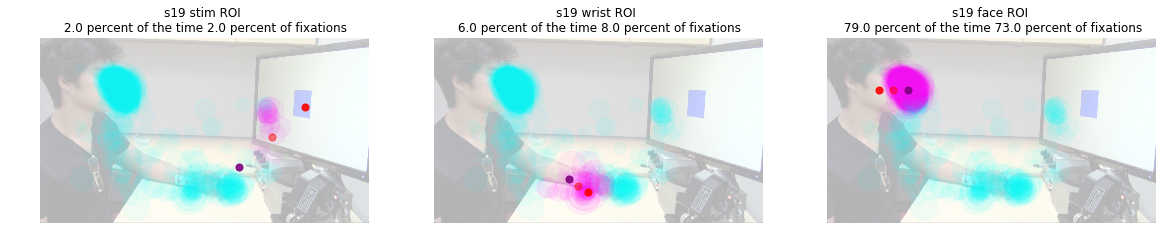

In [39]:
sub = subjects[0]

labels = main['CS'].keys()
print 'interval:', zip(labels, [round(mean(gaze_data[sub]['interval'][_type_])) for _type_ in labels])
print 'CS_offset:', zip(labels,[round(mean(gaze_data[sub]['CS_offset'][_type_])) for _type_ in labels])
print 'CS:', zip(labels,[round(mean(gaze_data[sub]['CS'][_type_])) for _type_ in labels]) 
print 'US_onset:', zip(labels,[round(mean(gaze_data[sub]['US_onset'][_type_])) for _type_ in labels])
show_subject_data(sub) 

In [48]:
# THE FUCK IS THIS SO SLOOOOOOOW? just save the data for now, and load it frmo another script..
# import gaze_functions as attention

In [49]:
# main, gaze_data, subjects = attention.return_gaze_analysis_data()

In [50]:
keys = main['CS'].keys()

In [57]:
_types_ = gaze_data[sub].keys()
keys = main['CS'].keys()
figure(figsize=[13,8])

for i_type in range(len(_types_)): 
    subplot(2,2,i_type+1)
    place = np.ones(len(gaze_data[sub][types[i_type]][keys[0]]))
    jitter = np.random.randn(len(place))/30
    [scatter(place-ii + jitter, gaze_data[sub][types[i_type]][keys[ii]], alpha=.2) for ii in range(len(keys))];
    xticks([1, 0, -1], [keys[0], keys[1], keys[2]])
    ylim(-5,110)
    title('subject %s during %s'%(sub, types[i_type]))

KeyError: 19

In [ ]:
print 'face v wrist' , ' p < %.4f' %stats.ttest_ind(gaze_data[sub]['US_onset']['face'], 
                                             gaze_data[sub]['US_onset']['wrist'])[1]
print 'face v stim' , ' p < %.4f' %stats.ttest_ind(gaze_data[sub]['US_onset']['face'], 
                                             gaze_data[sub]['US_onset']['stim'])[1]

In [ ]:
figure(figsize=[13,9])

count = 1
for i_type in types:
    place = np.ones(len(main[i_type][keys[0]]))
    subplot(2,2,count); count += 1     
    for i_key, j_key in zip(keys, range(len(keys))): 
        jitter = np.random.randn(len(place))/30
        scatter(place-j_key+jitter, main[i_type][i_key], alpha=.2) 
    xlim(-1.5,1.5)
    xticks([1, 0, -1], [keys[0], keys[1], keys[2]])
    ylim(-10,110)
    yticks([0,50,100])
    ylabel('percent of looking time')
    
    title(i_type)

In [ ]:
compare = 'face'
print compare , ' p < %.4f' %stats.ttest_ind(main['US_onset']['stim'], main['CS'][compare])[1]
compare = 'stim'
print compare , ' p < %.4f' %stats.ttest_ind(main['US_onset']['stim'], main['CS'][compare])[1]
compare = 'wrist'
print compare , 'p < %.4f' %stats.ttest_ind(main['US_onset']['stim'], main['CS'][compare])[1]

print '\nsignificance of wrist after shock (p < %s)'%round(stats.ttest_1samp(main['US_onset']['wrist'], 0)[1],2)

In [ ]:
def roi_percent_analysis(subjects, show=0): 
        
    roi_data = {} 
    
    for i_subject in range(len(subjects)):
        
        subject_data = load_data(subjects[i_subject])
        data = extract_data(subject_data)
        structured_data = generate_clusters(data, show=0)
        centers = structured_data['k'].cluster_centers_
        duration = structured_data['data']['fixation']['duration']
        xy = structured_data['xy'] 

        _roi_ = {} 

        if show: plt.figure(figsize=[20,8]); i_plot = 1

        for i_reference in reference_points.keys(): 

            # calculate
            i_center = np.sum(abs(centers - reference_points[i_reference]),1).argmin()
            center_of_mass = centers[i_center,:] - (centers[i_center,:] - reference_points[i_reference])/2
            distance_from = np.sum(abs(xy - center_of_mass),1)
            include = distance_from < include_radius
            percent_ROI = round(sum(duration[include])/ sum(duration) * 100)
            n_ROI = round(len(duration[include])/ float(len(duration)) * 100)

            # save 
            _roi_[i_reference] = percent_ROI

            if show: 
                plt.subplot(1,3,i_plot); i_plot += 1 
                plt.imshow(model_image, alpha=.3) ; plt.axis('off')
                plt.scatter(xy[:,0], xy[:,1], c=include, s=data['fixation']['duration'], alpha=.05, cmap='cool', label='fixations')    
                plt.scatter(centers[i_center,0], centers[i_center,1], color='purple', s=50, alpha=.9, label='cluster COM')
                plt.scatter(reference_points[i_reference][0], reference_points[i_reference][1], color='red', s=50, alpha=.9, label='image reference')
                plt.scatter(center_of_mass[0], center_of_mass[1], color='red', s=50, alpha=.5, label='halfway')
                #plt.legend(fontsize=8)
                plt.title('s%s %s ROI \n %s percent of the time %s percent of fixations'%(subjects[i_subject], i_reference, percent_ROI, n_ROI))

        roi_data[i_subject] = _roi_ 
    
    return roi_data

In [ ]:
# def temporal_gaze_analysis(subject_data, reference_points, include_radius, interval_length):
            
#     # extract relevent information
#     data = extract_data(subject_data)  

#     # identify CS and US timing withing gaze data # tyler: combine functions later
#     US_onsets, CS_onsets, CS_offsets, reinforcement = extract_time_info(subject_data)
    
#     # generate clusters 
#     structured_data = generate_clusters(data, show=0)
    
#     # extract centers of each cluster
#     centers = structured_data['k'].cluster_centers_
    
#     # high level analysis types
#     analysis_types = ['CS_onset', 
#                       'US_onset', 
#                       'CS_offset']
    
#     # global data structure
#     gaze_analysis = {}
    
#     for analysis in analysis_types: 
        
#         gaze_analysis
#         # determine sample rate with known interval (CS length = 4 seconds)
#         sample_rate = (int(CS_offsets[0][1]) - int(CS_onsets[0][1])) / 4

#         # specific options for CS or US 
#         if   analysis == 'CS_onset' :  n_stimuli = len(CS_on)
#         elif analysis == 'US_onset' :  n_stimuli = len(US)        
#         elif analysis == 'CS_offset':  n_stimuli = len(CS_off)
            
#         # time and location info of fixation
#         fix_time = np.array(data['fixation']['time']) 
#         fix_xy = np.array(data['fixation']['xy']) 
#         fix_duration = np.array(data['fixation']['duration'])
        
#         # time and location infor for all eye data
#         gaze_time = np.array(data['xy_time']) 
#         gaze_xy = np.array(data['xy']) 
        
#         for i_stim in range(n_stimuli): 

#             # define type_dependent interval to look over
#             if analysis == 'CS_onset': 

#                 stimulus_onset  = int(CS_onsets[i_stim][1])
#                 stimulus_offset = int(CS_offsets[i_stim][1])                
#                 roi_data['type'].append(CS_onsets[i_stim][2][-3:])
            
#             if analysis == 'US_onset': 
                
#                 # US is 1 second after US onset signal sent to eyelink
#                 stimulus_onset  = int(US_onsets[i_stim][1]) + sample_rate * 1
#                 stimulus_offset = stimulus_onset + sample_rate * interval_length

#             if analysis == 'CS_offset':
                
#                 stimulus_onset  = int(CS_offsets[i_stim][1]) 
#                 stimulus_offset = stimulus_onset + sample_rate * interval_length

#             # find indices for time we're interested in
#             gaze_analysis_window = (gaze_time < stimulus_offset) & (gaze_time > stimulus_onset)
#             fix_analysis_window = (fix_time  < stimulus_offset) & (fix_time  > stimulus_onset)
            
#             # extract indices from fixation and gaze timecourses
#             i_gaze_xy = gaze_xy[gaze_analysis_window]
#             i_fix_xy  = fix_xy[fix_analysis_window]
#             i_fix_dur = duration[fix_analysis_window]

#             stim_sum_f, stim_sum_g = [], []
            
#             # iterate through AOIs (face, wrist, stim)
#             for i_reference in reference_points.keys(): 

#                 # find which cluster-based center is closest to the image-based center
#                 i_center = np.sum(abs(centers - reference_points[i_reference]),1).argmin()
                
#                 # find halfway point between image and cluster based center of mass 
#                 center_of_mass = centers[i_center,:] - (centers[i_center,:] - reference_points[i_reference])/2
            
#                 # calculate distance between each measure and AOI
#                 distance_from_gaze      = np.sum(abs(i_gaze_xy - center_of_mass),1)
#                 distance_from_fixation  = np.sum(abs(i_fix_xy  - center_of_mass),1)
                
               
#                 # determine which indices are within the AOI
#                 include_gaze     = distance_from_gaze     < include_radius
#                 include_fixation = distance_from_fixation < include_radius

#                 # calculate percentage of measures that fall within the AOI 
#                 percent_fixation_ROI = sum(i_fix_dur[include_fixation]) / sum(i_fix_dur)
#                 percent_gaze_ROI     = (100* sum(include_gaze) / float(len(i_gaze_xy))) 

                
#                 # remove nans
#                 if percent_fixation_ROI != percent_fixation_ROI: percent_fixation_ROI = 0.0
#                 if percent_gaze_ROI     != percent_gaze_ROI    : percent_gaze_ROI     = 0.0

#                 roi_data[i_reference]['gaze'].append(percent_gaze_ROI)
#                 roi_data[i_reference]['fixation'].append(percent_fixation_ROI)
                
#                 stim_sum_g.append(percent_gaze_ROI)
#                 stim_sum_f.append(percent_fixation_ROI)
            
#             roi_data[i_reference]['sum_gaze'].append(sum(stim_sum_g))
#             roi_data[i_reference]['sum_fixation'].append(sum(stim_sum_f))

#         gaze_analysis[analysis] = roi_data
        
#     return gaze_analysis, roi_data
 